# Neural Network with PyTorch

In [60]:
!pip install openpyxl
!pip install torchsummary

In [61]:
import matplotlib.pyplot as plt

from preprocessing import trainTestClean
#from preprocessing_dropna import trainTestCleanDropNa
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import pandas as pd
import numpy as np

In [46]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load data

In [47]:
df_train, df_test = trainTestClean()
#df_train, df_test = trainTestCleanDropNa()

X_train = df_train.drop(columns=['price'])
y_train = df_train['price']
X_test = df_test.drop(columns=['price'])
y_test = df_test['price']

X_test = X_test[X_train.columns]

In [48]:
X_test.head()

,id,bedroomCount,bathroomCount,postCode,habitableSurface,hasAttic,hasBasement,buildingCondition,buildingConstructionYear,hasLift,floodZoneType,hasHeatPump,hasPhotovoltaicPanels,hasThermicPanels,landSurface,hasLivingRoom,livingRoomSurface,hasGarden,gardenSurface,parkingCountIndoor,parkingCountOutdoor,hasAirConditioning,hasArmoredDoor,hasVisiophone,hasOffice,toiletCount,hasSwimmingPool,hasFireplace,hasTerrace,terraceSurface,epcScore,facadeCount,isHouse,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Limburg,province_Liège,province_Luxembourg,province_Namur,province_Walloon Brabant,province_West Flanders,heating_CARBON,heating_ELECTRIC,heating_FUELOIL,heating_GAS,heating_PELLET,heating_SOLAR,heating_WOOD,kitchen_HYPER_EQUIPPED,kitchen_INSTALLED,kitchen_NOT_INSTALLED,kitchen_SEMI_EQUIPPED,kitchen_USA_HYPER_EQUIPPED,kitchen_USA_INSTALLED,kitchen_USA_SEMI_EQUIPPED,kitchen_USA_UNINSTALLED,pricePerM2,subtype_APARTMENT,subtype_APARTMENT_BLOCK,subtype_BUNGALOW,subtype_CASTLE,subtype_CHALET,subtype_COUNTRY_COTTAGE,subtype_DUPLEX,subtype_EXCEPTIONAL_PROPERTY,subtype_FARMHOUSE,subtype_FLAT_STUDIO,subtype_GROUND_FLOOR,subtype_HOUSE,subtype_KOT,subtype_LOFT,subtype_MANOR_HOUSE,subtype_MANSION,subtype_MIXED_USE_BUILDING,subtype_OTHER_PROPERTY,subtype_PENTHOUSE,subtype_SERVICE_FLAT,subtype_TOWN_HOUSE,subtype_TRIPLEX,subtype_VILLA,terraceOrientation_0,terraceOrientation_EAST,terraceOrientation_NORTH,terraceOrientation_NORTH_EAST,terraceOrientation_NORTH_WEST,terraceOrientation_SOUTH,terraceOrientation_SOUTH_EAST,terraceOrientation_SOUTH_WEST,terraceOrientation_WEST,kde_price_per_m2_knn,has_kde_score
0,20543393,3,1,4317,168.0,1,1,-1,1974,0,0,0,0,0,683.0,1,23.0,1,500.0,0,0,0,0,0,0,1,0,0,1,1.0,330,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1428.571429,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000426,1
1,20371063,5,2,4121,279.0,0,1,3,1994,0,0,0,1,0,3124.0,1,40.0,1,3124.0,1,0,0,0,0,0,2,0,0,1,30.0,250,4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,2326.164875,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000481,1
3,20537164,3,1,2140,172.0,0,1,3,1981,0,0,0,0,0,80.0,1,40.0,1,22.0,1,0,0,0,0,0,1,0,0,1,4.0,200,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,2296.511628,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000543,1
5,20524364,3,2,1150,110.0,0,0,3,1974,0,0,0,0,0,444.0,0,0.0,0,0.0,0,0,0,0,0,0,1,0,0,1,7.0,95,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,4454.545455,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000458,1
6,20583008,2,1,9940,73.0,0,0,-1,2005,0,0,0,0,0,444.0,1,0.0,0,0.0,0,0,0,0,1,0,1,0,0,0,0.0,200,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,2904.109589,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.000489,1


In [49]:
y_test.head()

0    240000.0
1    649000.0
3    395000.0
5    490000.0
6    212000.0
Name: price, dtype: float64

In [50]:
# Size of tensor :
head_size = X_train.drop(columns=['id']).shape[1]
head_size

93

## Create the model

In [52]:
model = nn.Sequential(
    nn.Linear(head_size, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(128, 1)
)

## Initialize the weights

In [53]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)

Sequential(
  (0): Linear(in_features=93, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=1, bias=True)
)

In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss() 

x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train.drop(columns=['id']))
X_test = x_scaler.transform(X_test.drop(columns=['id']))

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



## Train the model

In [55]:
epochs = 200
batch_size = 32

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

best_val_loss = float('inf')
patience = 35
trigger_times = 0
losses = []
val_losses = []
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for batch_X, batch_y in dataloader:

        batch_X = batch_X.clone().detach()
        batch_y = batch_y.clone().detach()

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        loss_val = criterion(val_outputs, y_test_tensor)
    epoch_loss = running_loss / len(dataloader)
    losses.append(epoch_loss)
    val_losses.append(loss_val)
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {loss_val.item():.4f}")

    if loss_val.item() < best_val_loss:
        best_val_loss = loss_val.item()
        trigger_times = 0
        best_model_state = model.state_dict() 
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch [1/200], Train Loss: 1.0128, Validation Loss: 0.3974
Epoch [11/200], Train Loss: 0.1112, Validation Loss: 0.2842
Epoch [21/200], Train Loss: 0.2816, Validation Loss: 0.3916
Epoch [31/200], Train Loss: 0.0367, Validation Loss: 0.2518
Epoch [41/200], Train Loss: 0.0824, Validation Loss: 0.1569
Epoch [51/200], Train Loss: 0.3713, Validation Loss: 0.1564
Epoch [61/200], Train Loss: 0.1027, Validation Loss: 0.1822
Epoch [71/200], Train Loss: 0.2103, Validation Loss: 0.1441
Epoch [81/200], Train Loss: 0.0726, Validation Loss: 0.1585
Epoch [91/200], Train Loss: 0.0517, Validation Loss: 0.3949
Early stopping triggered at epoch 100


## Plot the loss

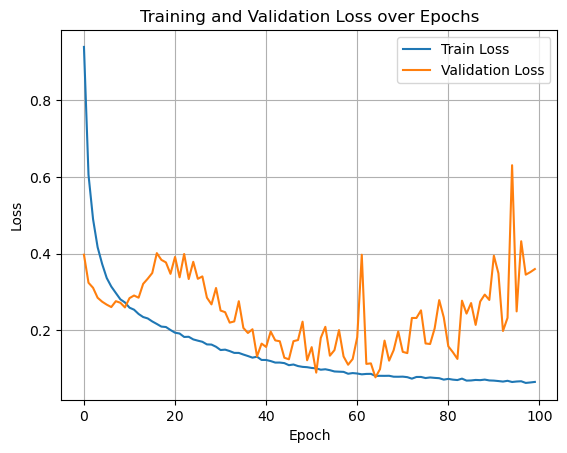

In [56]:
plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate the model

In [57]:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(X_test, dtype=torch.float32)
    targets = torch.tensor(y_test, dtype=torch.float32)

    model.load_state_dict(best_model_state)
    predictions_scaled = model(inputs).squeeze()

    predictions = y_scaler.inverse_transform(predictions_scaled.reshape(-1, 1))
    predictions = torch.tensor(predictions, dtype=torch.float32).squeeze()

    targets = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    targets = torch.tensor(targets, dtype=torch.float32).squeeze()
    
    mae_value = F.l1_loss(predictions, targets, reduction='mean')
    mse_value = F.mse_loss(predictions, targets, reduction='mean')

    errors = torch.abs(predictions - targets)
    mape = torch.mean(100 * errors / (targets + 1e-8))

    print(f"MAE = {mae_value.item():.4f}, MSE = {mse_value.item():.4f}, MAPE = {mape:.4f}%")

MAE = 20137.0430, MSE = 12437147648.0000, MAPE = 6.5109%


In [58]:
# calculate the metrics
def calculate_metrics(model, X, y, y_scaler=None):
    model.eval()
    with torch.no_grad():
        inputs = X
        targets = y
        model.load_state_dict(best_model_state)
        
        predictions_scaled = model(inputs).squeeze()

        if y_scaler:
            predictions = y_scaler.inverse_transform(predictions_scaled.reshape(-1, 1))
            predictions = torch.tensor(predictions, dtype=torch.float32).squeeze()
            targets = y_scaler.inverse_transform(targets.reshape(-1, 1))
            targets = torch.tensor(targets, dtype=torch.float32).squeeze()
        else:
            predictions = predictions_scaled

        # MAE, MSE, RMSE
        mae_value = F.l1_loss(predictions, targets, reduction='mean')
        mse_value = F.mse_loss(predictions, targets, reduction='mean')
        rmse_value = torch.sqrt(mse_value)

        # R2
        total_variance = torch.var(targets)
        residual_variance = torch.var(targets - predictions)
        r2_value = 1 - residual_variance / total_variance

        # MAPE
        errors = torch.abs(predictions - targets)
        mape = torch.mean(100 * errors / (targets + 1e-8))  # éviter la division par zéro

        return r2_value.item(), mae_value.item(), mse_value.item(), rmse_value.item(), mape.item()

# Train
r2_train, mae_train, mse_train, rmse_train, mape_train = calculate_metrics(model, X_train_tensor, y_train_tensor, y_scaler)

print(f"Train : R2 = {r2_train:.4f}, MAE = {mae_train:.4f}, MSE = {mse_train:.4f}, RMSE = {rmse_train:.4f}, MAPE = {mape_train:.4f}%")

# Test
r2_test, mae_test, mse_test, rmse_test, mape_test = calculate_metrics(model, X_test_tensor, y_test_tensor, y_scaler)

print(f"Test : R2 = {r2_test:.4f}, MAE = {mae_test:.4f}, MSE = {mse_test:.4f}, RMSE = {rmse_test:.4f}, MAPE = {mape_test:.4f}%")

Train : R2 = 0.2998, MAE = 17843.6152, MSE = 24208351232.0000, RMSE = 155590.3281, MAPE = 5.7689%
Test : R2 = 0.6426, MAE = 20137.0430, MSE = 12437147648.0000, RMSE = 111521.9609, MAPE = 6.5109%


In [62]:
summary(model, (93,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          48,128
       BatchNorm1d-2                  [-1, 512]           1,024
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
       BatchNorm1d-6                  [-1, 256]             512
              ReLU-7                  [-1, 256]               0
           Dropout-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
      BatchNorm1d-10                  [-1, 128]             256
             ReLU-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 1]             129
Total params: 214,273
Trainable params:

## Save Model :

In [59]:
torch.save(best_model_state, "best_model.pth")

# and to load it :
#model.load_state_dict(torch.load("best_model.pth"))
#model.eval()
# -> dont forget model.eval to deactivate batchnorm, dropout,...